In [32]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Adam import Adam
from gru2 import GRUModel
from timeit import default_timer
import operator
from functools import reduce
from functools import partial
from normal import UnitGaussianNormalizer
from matplotlib import cm
import scipy.io
from utilities3 import LpLoss

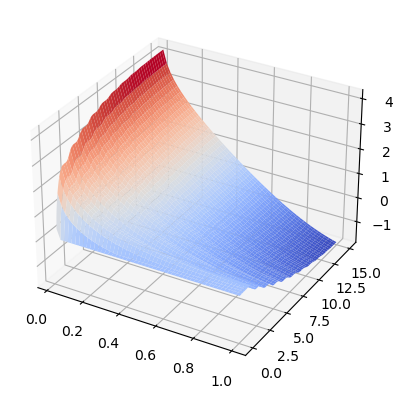

In [33]:
# Load Data

L = 1
T = 14.95
dt = 0.05
dx = 0.02
nt = int(round(T/dt))
nx = int(round(L/dx))
npoints = 1000

t1 = np.linspace(0.05, T, nt)
x1 = np.linspace(0.02, L, nx)

x = scipy.io.loadmat("u.mat")["uData"]
x = x.reshape(npoints, nt, nx).astype(np.float32)
y = scipy.io.loadmat("thetaHat.mat")["tHatData"]
y = y.reshape(npoints, nt, nx).astype(np.float32)
    


x1, t1 = np.meshgrid(x1, t1)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, y[0, :, :], cmap=cm.coolwarm)

In [34]:
# Parameters
epochs =1000
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 50
modes = 12
width = 32

In [35]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()


trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [36]:
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [37]:
#model = GRUModel(300, 1024, 300, 1, 3, [512, 128, 64]).cuda()
model = GRUModel(500, 50, 50).cuda()
print(count_params(model))

853050


In [38]:
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [39]:
t = default_timer()
loss = LpLoss()
train_mseArr = []
test_mseArr = []
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)

        mse = loss(out, y)
        mse.backward()
        
        optimizer.step()
        train_mse += mse.item()
        
    scheduler.step()
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model(x)
            test_mse += loss(out, y).item()
            
    train_mse /= len(trainData)
    test_mse /= len(testData)
    
    train_mseArr.append(train_mse)
    test_mseArr.append(test_mse)
    
    t2 = default_timer()
    if ep%50 == 0:
        print(ep, t2-t1, train_mse, test_mse)
print(default_timer()-t)

0 0.5160221820697188 0.5956809361775716 0.47401230335235595
50 0.4892479828558862 0.04241830309232076 0.03978079110383988
100 0.48865614272654057 0.026756012274159326 0.024533432349562644
150 0.48918999871239066 0.019759616028103562 0.02022690884768963
200 0.48891997430473566 0.01671604679690467 0.017612899467349053
250 0.4919179570861161 0.015064247904552354 0.0164666585624218
300 0.4920122460462153 0.01387939200633102 0.015506848134100438
350 0.49187915911898017 0.013454793103867107 0.01519362088292837
400 0.4920478072017431 0.013198845471358961 0.014994407072663307
450 0.4991486081853509 0.013083142849306265 0.014926762878894806
500 0.4922416852787137 0.013020593093501197 0.014866858161985875
550 0.49187522707507014 0.012987038037843174 0.014839698746800422
600 0.4922980940900743 0.012971312407818106 0.01482882108539343
650 0.4899554867297411 0.012962732702079746 0.014822277054190636
700 0.5033991825766861 0.012958304294281535 0.01481890883296728
750 0.4849582901224494 0.01295628710

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


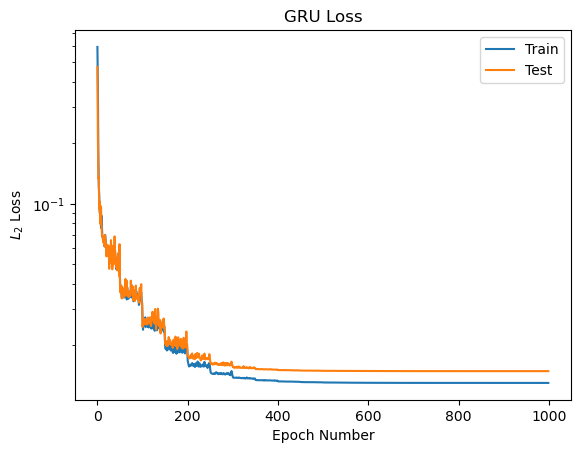

In [45]:
plt.title("GRU Loss")
plt.plot(train_mseArr, label="Train")
plt.plot(test_mseArr, label="Test")
plt.yscale("log")
plt.xlabel("Epoch Number")
plt.ylabel(r"$L_2$ Loss")
plt.legend()
plt.savefig('gru.eps')

In [41]:
torch.save(model.state_dict(), 'gruModel1')

tensor(57.4656, device='cuda:0')
tensor(59.4017, device='cuda:0')
tensor(58.2076, device='cuda:0')
tensor(75.4716, device='cuda:0')
tensor(51.0442, device='cuda:0')


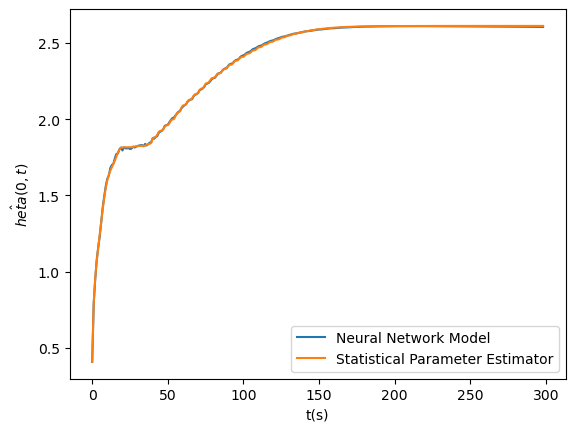

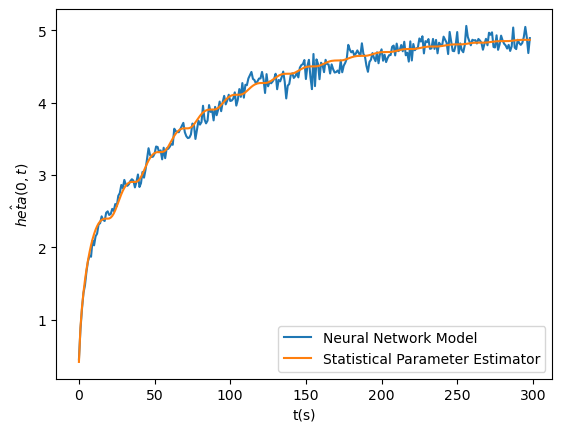

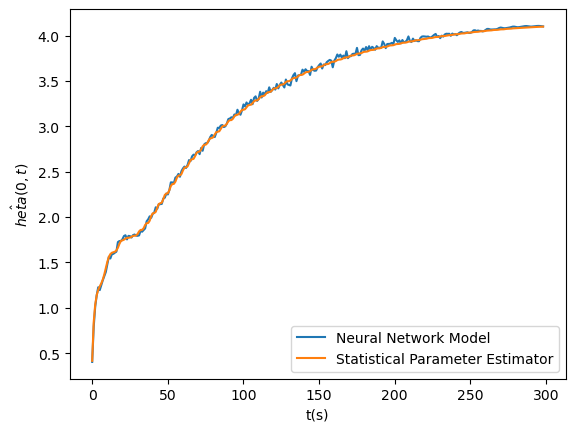

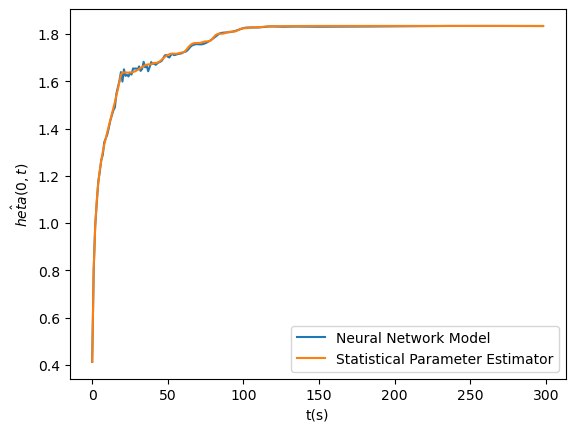

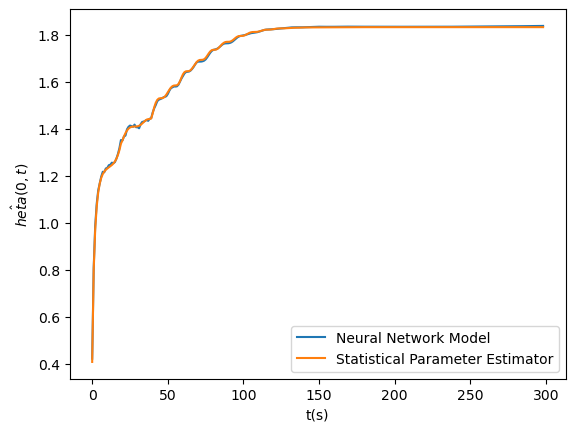

In [55]:
# Show some examples at the boundry
with torch.no_grad():
    for x, y in testData:
        x, y = x.cuda(), y.cuda()   
        out = model(x)
        plt.figure()
        print(x[0, 0, 0])
        plt.plot(out[0,:, 0].detach().cpu(), label="Neural Network Model")
        plt.plot(y[0, :, 0].detach().cpu(), label="Statistical Parameter Estimator")
        plt.legend()
        plt.xlabel("t(s)")
        plt.ylabel("$\hat{\theta}(0, t)$")

Text(0.5, 0, '$\\tilde{\\hat{\\theta}}$')

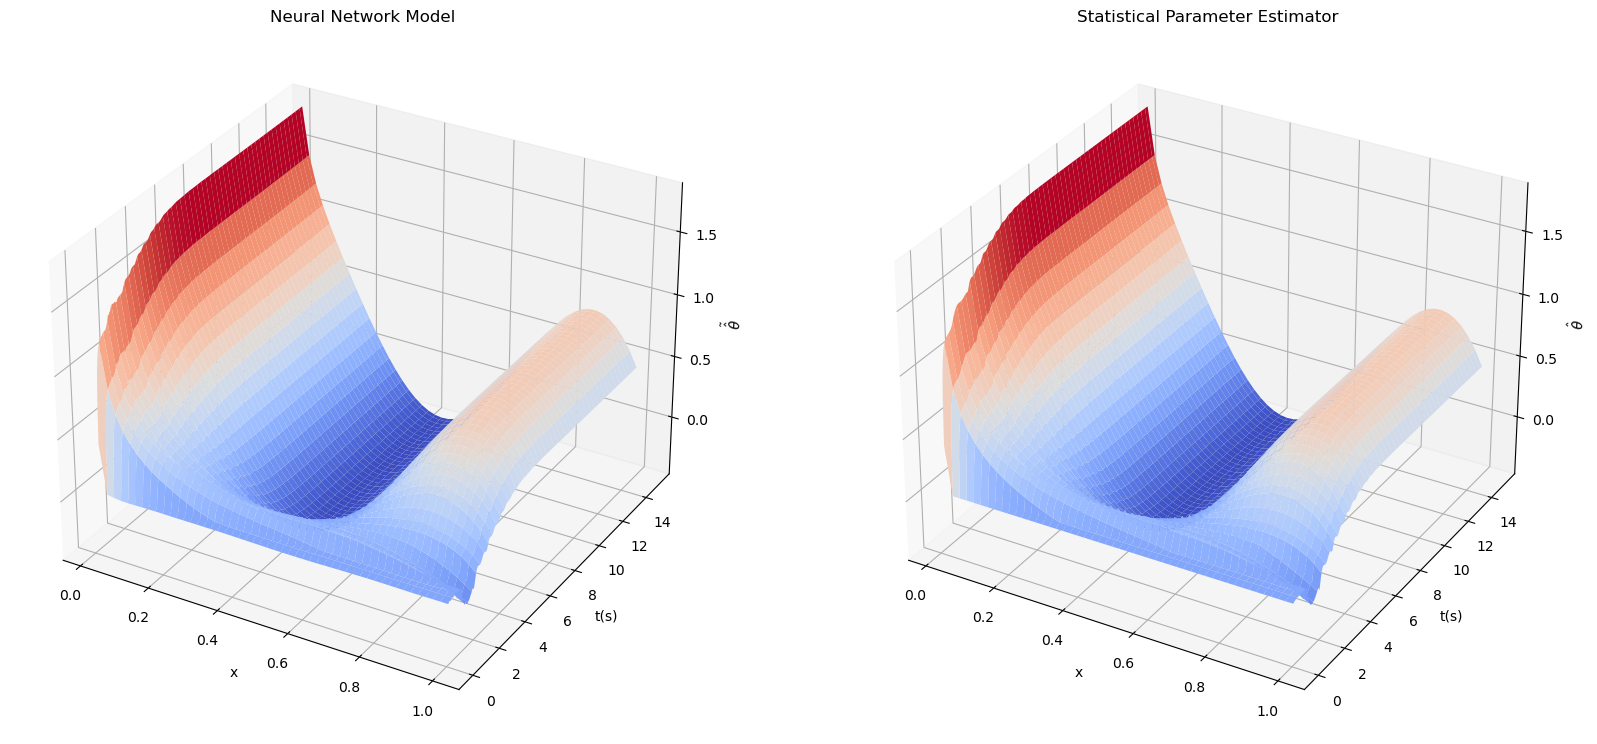

In [47]:
t1 = np.linspace(0.05, T, nt)
x1 = np.linspace(0.02, L, nx)
x1, t1 = np.meshgrid(x1, t1)

fig, ax = plt.subplots(1, 2,figsize=(20, 20), subplot_kw={"projection": "3d"})
surf = ax[0].plot_surface(x1, t1, out.cpu().detach().numpy()[0, :, :], cmap=cm.coolwarm, label="Neural Network Model")
surf = ax[1].plot_surface(x1, t1, y.cpu().detach().numpy()[0, :, :], cmap=cm.coolwarm, label="Statistical Parameter Estimator")
ax[0].title.set_text("Neural Network Model")
ax[1].title.set_text("Statistical Parameter Estimator")
ax[0].set_xlabel("x")
ax[1].set_xlabel("x")
ax[0].set_ylabel("t(s)")
ax[1].set_ylabel("t(s)")
ax[1].set_zlabel(r'$\hat{\theta}$')
ax[0].set_zlabel(r'$\tilde{\hat{\theta}}$')

In [44]:
with torch.no_grad():
    test_mse = 0
    mse_end = 0
    for x, y in testData:
        x, y = x.cuda(), y.cuda()
        t1 = time.time()
        out = model(x)
        t2 = time.time()

        test_mse += loss(out, y).item()
print("TEST MSE For 20 Instances:", test_mse/len(testData))

NameError: name 'time' is not defined

In [ ]:
torch.save(model.state_dict(), 'gruModel1')